In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.signal import find_peaks

In [3]:
# load data
data = loadmat('data/heartbeat_data/001.mat')
sr = 360  # sampling rate for synthetic data
#print(data['val'].shape)  # shape (1, 4, 1500)
signal_data = data['val'][0]
print(signal_data.shape)

(4, 2365)


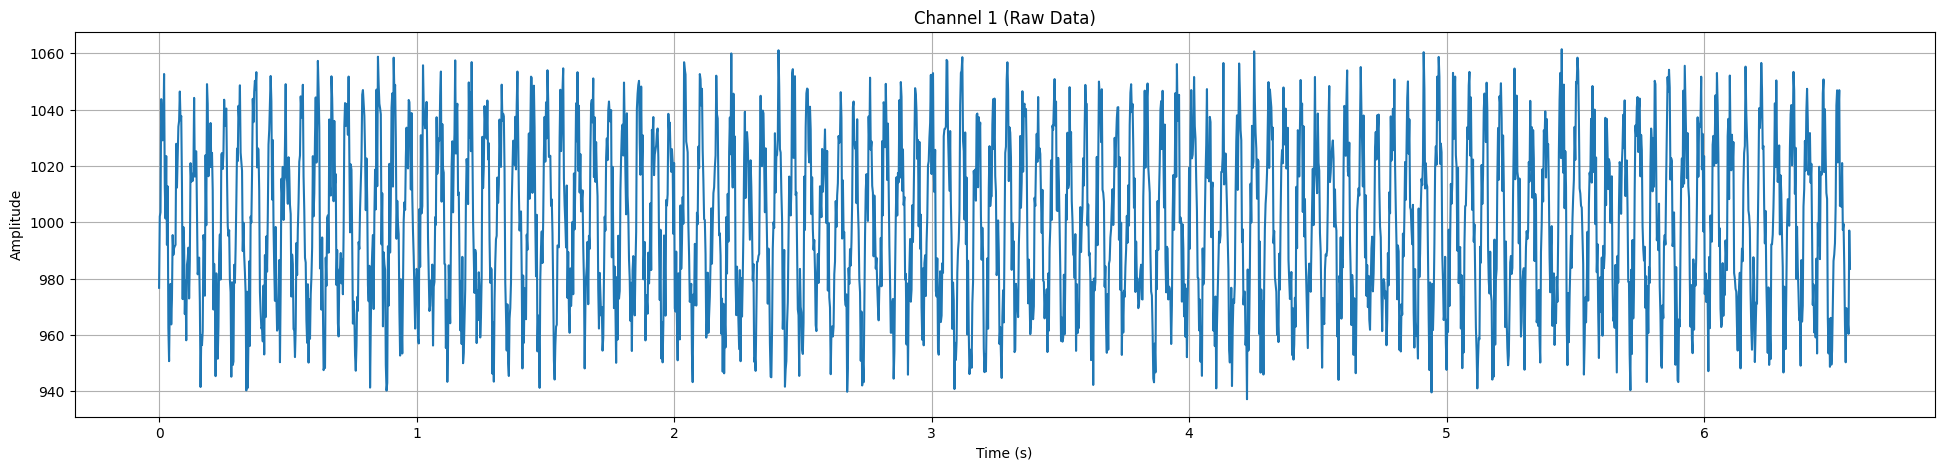

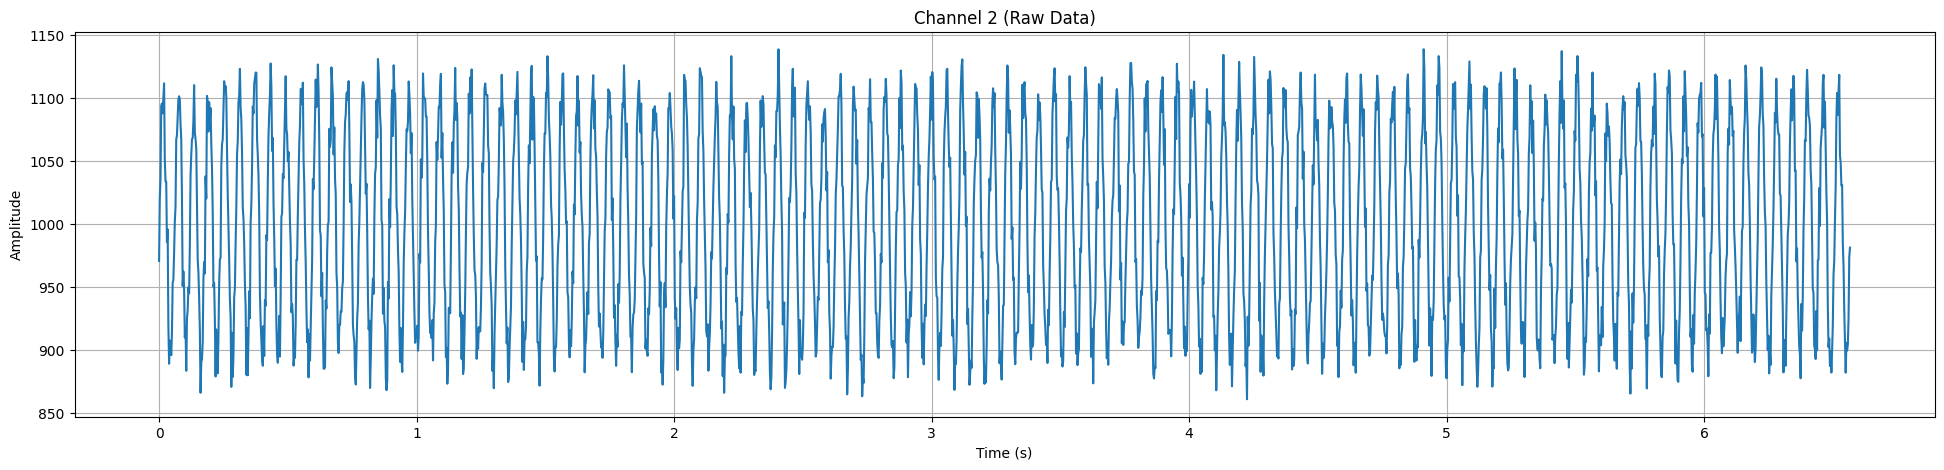

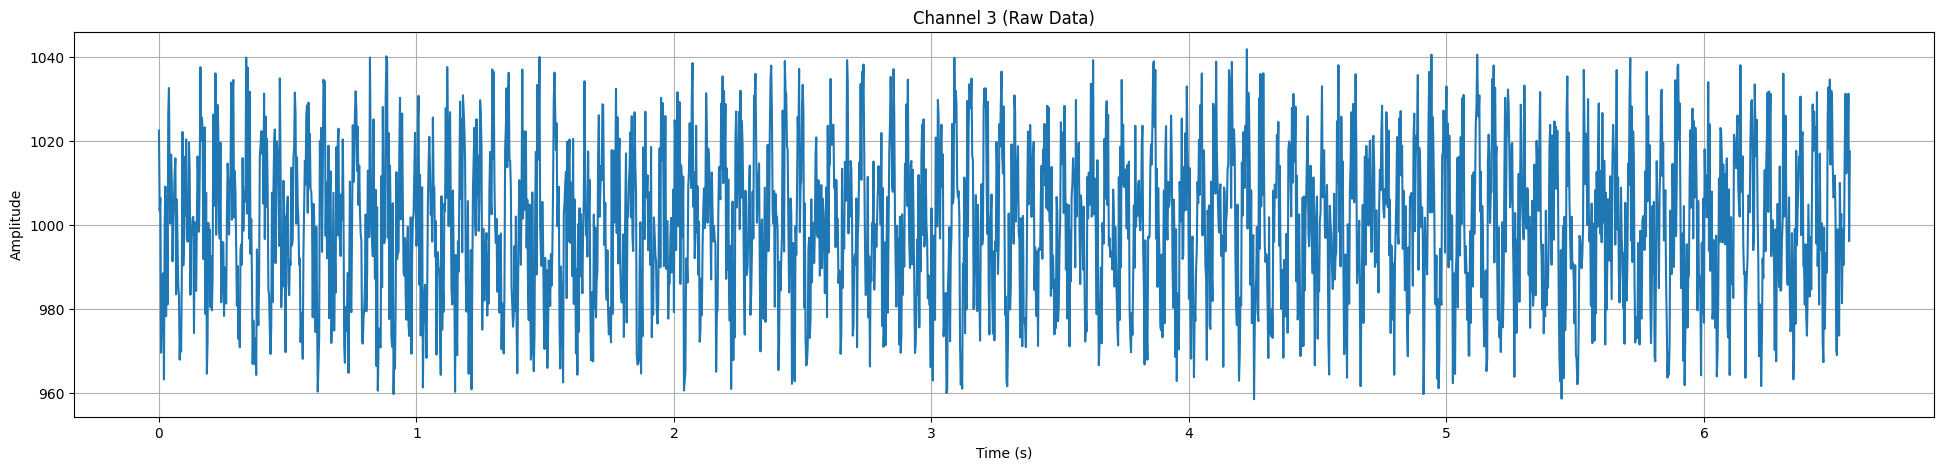

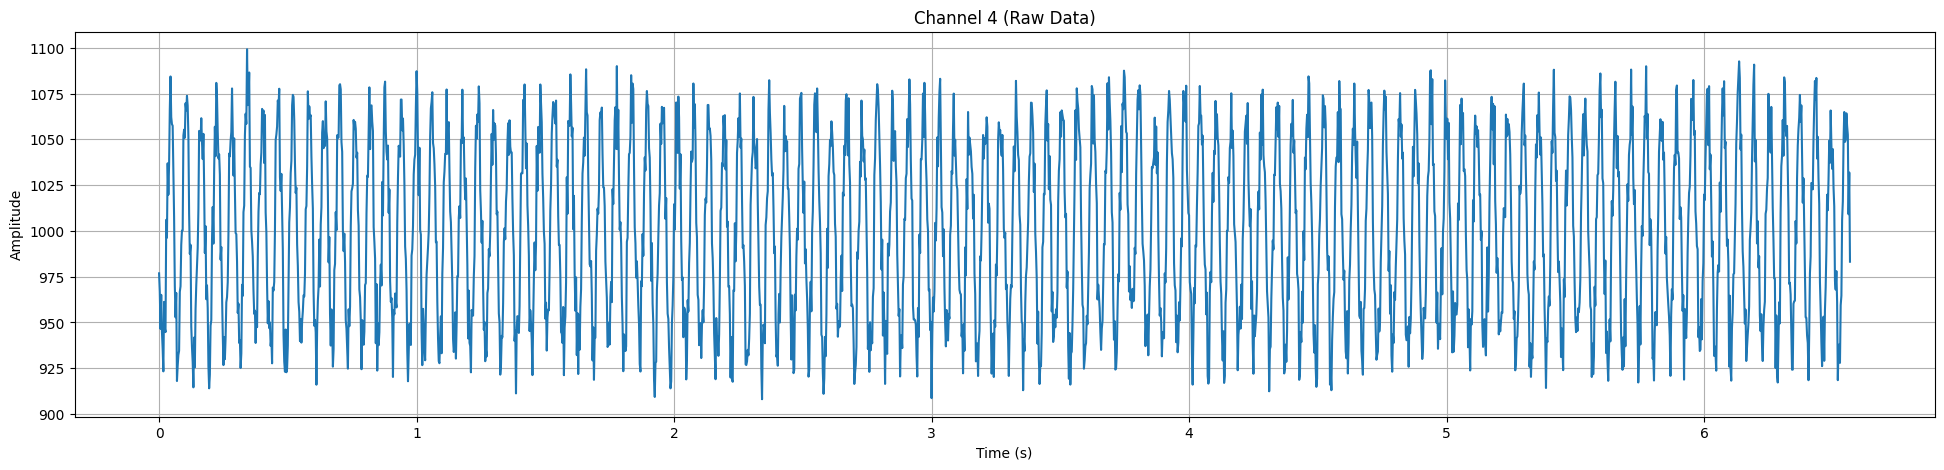

In [4]:
# plot the 4 recorded channels
for i in range(4):
    plt.figure(figsize=(24, 5))
    channel_data = signal_data[i]  # Extract raw data for each channel
    plt.plot(np.arange(0, len(channel_data) / sr, 1 / sr), channel_data)
    plt.title(f"Channel {i+1} (Raw Data)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
plt.show()

frequency analysis to determine if heartbeat is maternal/fetal
- fetal is lower-amplitude, faster oscillation
use Fourier transform (?)


The average fetal heart rate is between 110 and 160 beats per minute. It can vary by 5 to 25 beats per minute. The fetal heart rate may change as your baby responds to conditions in your uterus. An abnormal fetal heart rate may mean that your baby is not getting enough oxygen or that there are other problems
(https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/fetal-heart-monitoring#:~:text=The%20average%20fetal%20heart%20rate,that%20there%20are%20other%20problems.)

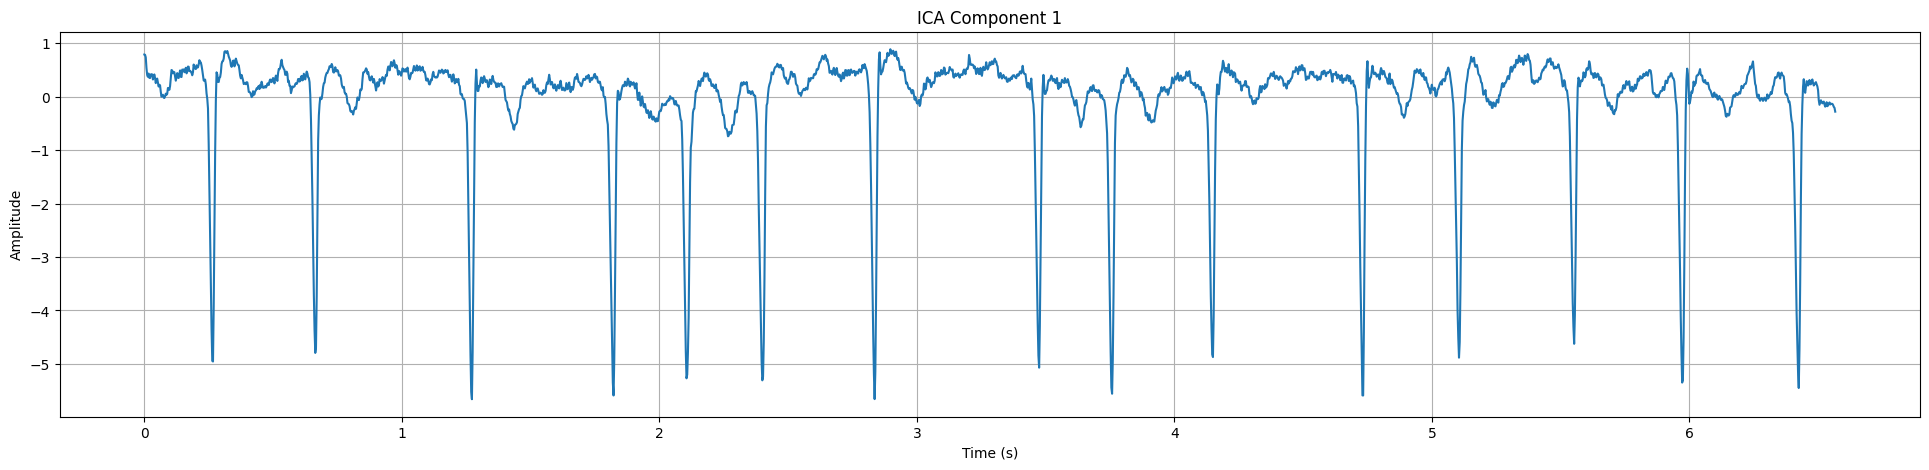

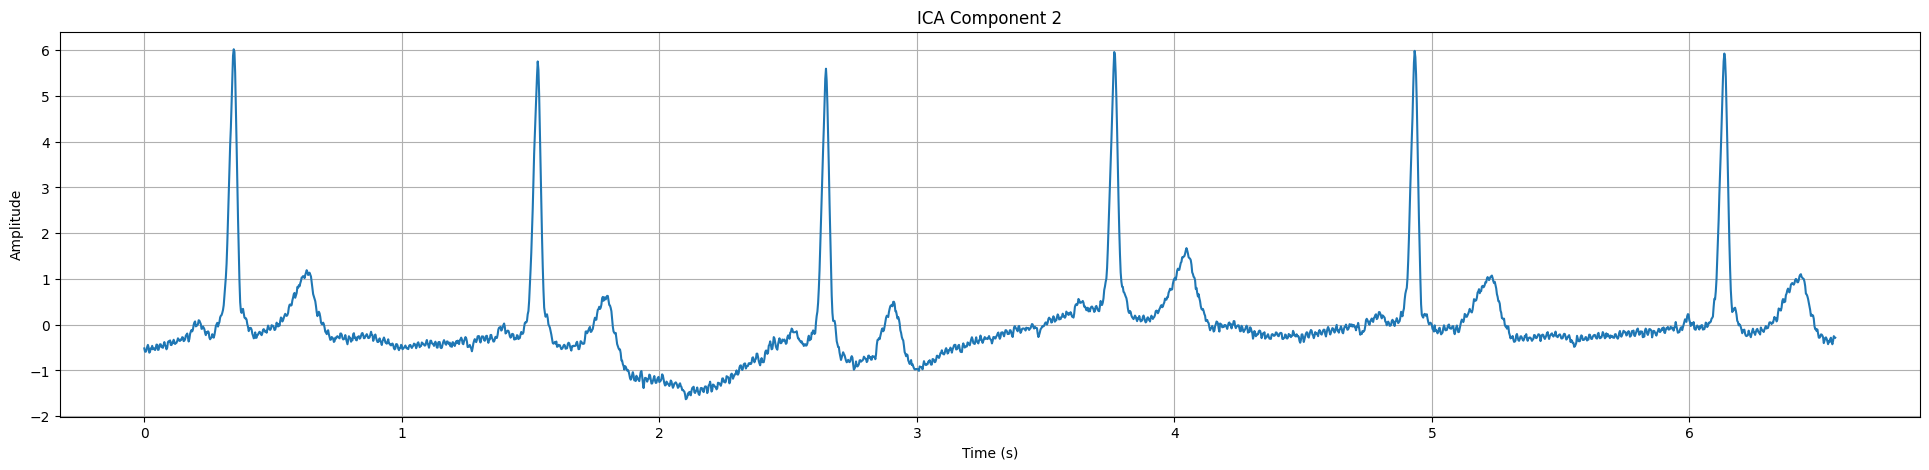

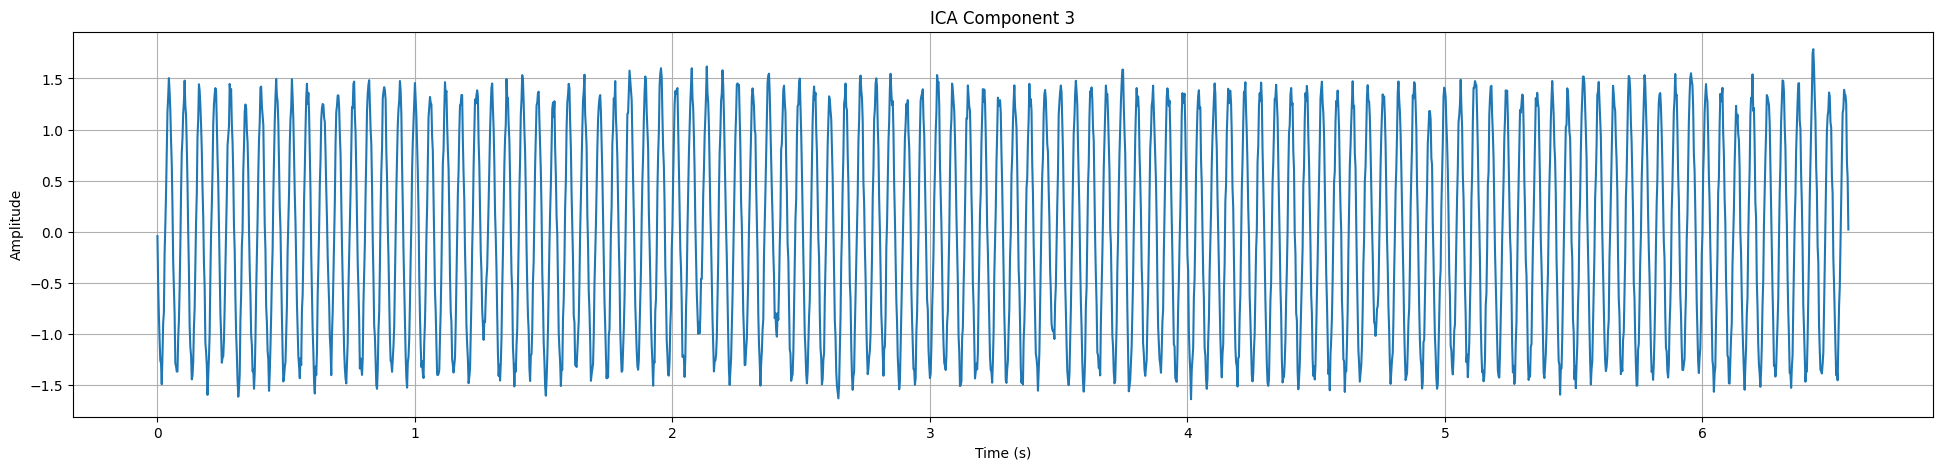

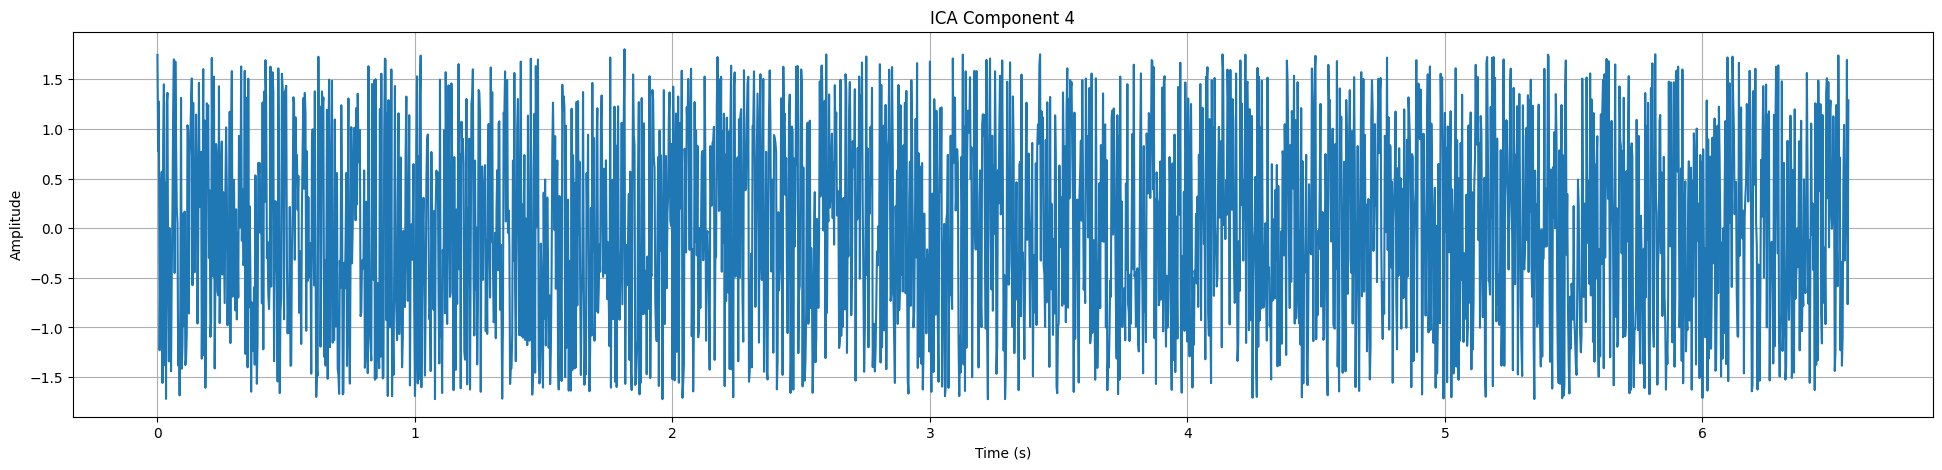

In [5]:
# apply ICA
ica = FastICA(n_components=4, random_state=42)
components = ica.fit_transform(signal_data.T)  # shape will be (n_samples, n_components)

# plot the ICA components
for i in range(4):
    component = components[:, i]

    plt.figure(figsize=(24, 5))
    plt.plot(np.arange(0, len(component) / sr, 1 / sr), component)
    plt.title(f"ICA Component {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
plt.show()

Component 1 - Heart Rate Analysis:
  bpm: 136.40
  ibi: 439.88
  sdnn: 113.46
  sdsd: 100.50
  rmssd: 177.02
  pnn20: 0.92
  pnn50: 0.77
  hr_mad: 88.89
  sd1: 125.13
  sd2: 109.10
  s: 42891.40
  sd1/sd2: 1.15
  breathingrate: 0.16
Fetal
Abnormality Analysis: Abnormalities detected: High heart rate variability (may indicate irregular rhythm).


<Figure size 1200x400 with 0 Axes>

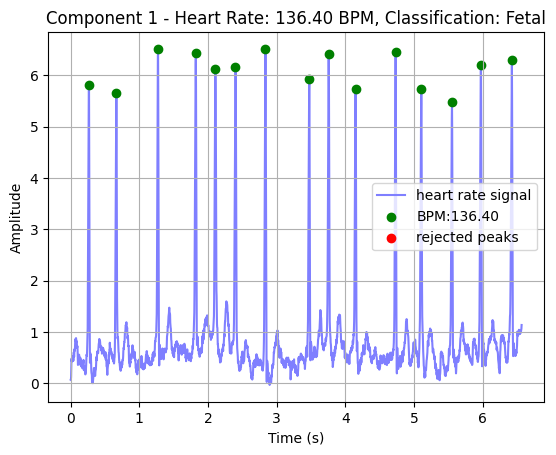

Component 2 - Heart Rate Analysis:
  bpm: 51.82
  ibi: 1157.78
  sdnn: 33.35
  sdsd: 22.65
  rmssd: 42.63
  pnn20: 0.75
  pnn50: 0.25
  hr_mad: 36.11
  sd1: 29.89
  sd2: 33.06
  s: 3103.67
  sd1/sd2: 0.90
  breathingrate: 0.17
Maternal


<Figure size 1200x400 with 0 Axes>

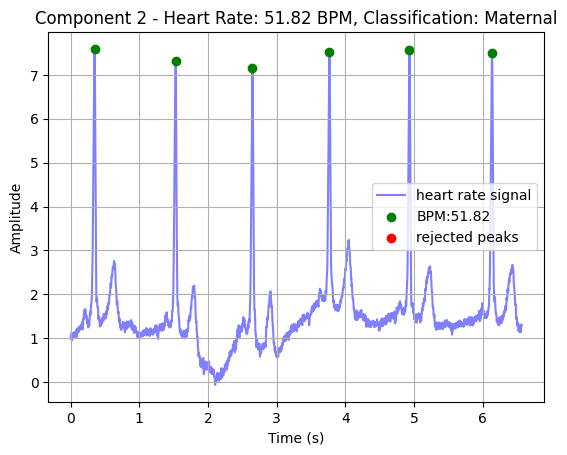

BadSignalWarning: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------


In [ ]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import heartpy as hp

def analyze_fetal_abnormalities(heart_rate, measures):
    """
    Analyze the fetal heart rate signal for potential abnormalities.
    
    Parameters:
        heart_rate (float): Calculated heart rate.
        measures (dict): HeartPy measures containing HRV metrics.
    
    Returns:
        str: Message indicating the presence of abnormalities or confirmation of normalcy.
    """
    abnormalities = []
    
    # Fetal heart rate normal range: 110 to 160 BPM
    if heart_rate < 110:
        abnormalities.append("Bradycardia detected (heart rate too low).")
    elif heart_rate > 160:
        abnormalities.append("Tachycardia detected (heart rate too high).")
    
    # Assess variability: RMSSD should ideally be within expected ranges
    rmssd = measures.get('rmssd', 0)
    if rmssd < 30:
        abnormalities.append("Low heart rate variability (may indicate stress or issues).")
    elif rmssd > 100:
        abnormalities.append("High heart rate variability (may indicate irregular rhythm).")
    
    # Assess decelerations or accelerations
    breathing_rate = measures.get('breathingrate', 0)
    if breathing_rate < 0.1 or breathing_rate > 0.5:
        abnormalities.append("Unusual breathing rate variability detected.")
    
    # Generate result
    if abnormalities:
        return "Abnormalities detected: " + "; ".join(abnormalities)
    else:
        return "Fetal heart rate appears normal."
    

def check_rotation(component, sr):
    distance = sr/10
    _, properties = find_peaks(component, distance=distance, height=0.1 * np.max(component))
    _ , inverted_properties = find_peaks(-component, distance=distance, height=0.1 * np.max(-component))

    # calculate average peak height for normal and inverted peaks to determine if signal is upside down or not
    avg_peak_height = np.mean(properties['peak_heights']) 
    avg_inv_peak_height = np.mean(inverted_properties['peak_heights']) 

    # flip signal if inverted peaks are taller
    if avg_inv_peak_height > avg_peak_height:
        component = -component

    return component


def calculate_heartrate(component, sr):
    component = check_rotation(component, sr)
    working_data, measures, heart_rate = None, None, None

    # Analyze the component signal with HeartPy
    working_data, measures = hp.process(component, sample_rate=sr)

    return component, working_data, measures


def dominant_frequency(component, sr):
    freqs = fftfreq(len(component), 1 / sr)
    fft_vals = np.abs(fft(component))
    peak_freq = freqs[np.argmax(fft_vals)]
    return abs(peak_freq)


def classify_signal(measures):
    heart_rate = measures['bpm']
    rmssd = measures['rmssd']
    sd1_sd2 = measures['sd1/sd2']
    breathingrate = measures['breathingrate']

    if 110 <= heart_rate <= 170 and rmssd > 50 and sd1_sd2 > 1:
        return "Fetal", heart_rate
    elif 40 <= heart_rate <= 100 and rmssd < 50 and breathingrate < 0.3:
        return "Maternal", heart_rate
    else:
        return "Unknown", heart_rate


def analyze_components(components, sr):
    for i in range(4):
        component = components[:, i]
        classification = 'Unknown'

        component, working_data, measures = calculate_heartrate(component, sr)
        if not working_data and not measures:
            continue

        classification, heart_rate = classify_signal(measures)

        if classification == "Fetal":
            abnormality_analysis = analyze_fetal_abnormalities(heart_rate, measures)
        
        # plot component and peaks
        plt.figure(figsize=(12, 4))
        if working_data and measures:
            #call plotter
            hp.plotter(working_data, measures)

            #display measures computed
            print(f"Component {i + 1} - Heart Rate Analysis:")
            for measure, value in measures.items():
                print(f"  {measure}: {value:.2f}")
            print(classification)
            if classification == "Fetal":
                print(f"Abnormality Analysis: {abnormality_analysis}")            
            plt.title(f"Component {i+1} - Heart Rate: {heart_rate:.2f} BPM, Classification: {classification}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid()

            plt.show()

# analyze components
analyze_components(components, sr)

In [120]:
# identify fetal and maternal heartbeats based on heart rate ranges
# maternal (60-100 bpm), fetal (110-160 bpm)

# heartpy ?